# Introduction

## Goals

- Parse LLM-generated JSON
- Deduplicate names and organisations
- Load data to SQLite for storage and analysis

In [1]:
import json
from json_repair import repair_json
import pandas as pd

# Load in the json from Vertex
with open("data/quotes/2_year.jsonl", "r") as f:
    quotes_og = [json.loads(line) for line in f]

with open("data/quotes/oct_update.jsonl", "r") as f:
    quotes_oct = [json.loads(line) for line in f]

quotes = quotes_og + quotes_oct

with open("data/newsapi/uk_2_year_filtered.json", "r") as f:
    uris = [i["uri"] for i in json.load(f)]

quotes = [q for q in quotes if q["key"] in uris]

# The quotes are stored on a per-article basis, we iterate over and parse the json
all_quotes = []

# Setup tracking for parsing
parse_tracker = {
    "success": 0,
    "repaired": 0,
    "failed": 0,
}

failed_records = []

for n, quote in enumerate(quotes):

    # Get id and the json string to parse
    idx = quote["key"]
    quote_string = quote["response"]["candidates"][0]["content"]["parts"][0][
        "text"
    ].strip()

    # There's inconsistent formatting, sometimes strings are wrapped in markdown
    if quote_string.startswith("```json"):
        quote_string = quote_string.replace("```json", "").replace("```", "")

    # Give it an initial try with standard json parsing
    try:
        quote_list = json.loads(quote_string)
        parse_tracker["success"] += 1

    # If that doesn't work, we try the `repair_json` library
    except:
        quote_string_repaired = repair_json(quote_string)
        try:
            quote_list = json.loads(quote_string_repaired)
            parse_tracker["repaired"] += 1

        # if that doesn't work, we give up
        except:
            quote_list = []
            print(f"Failed to parse JSON for {idx}")
            parse_tracker["failed"] += 1
            failed_records.append((idx, quote_string))

    # Bosh it into the quote list
    for q in quote_list:
        d = {"uri": idx, **q}
        all_quotes.append(d)

# Print parsing statistics
print(parse_tracker)

# Check failed records
print(f"Failed records: {failed_records}")

# Track length for later
initial_len = len(all_quotes)
dropped_rows = 0

{'success': 5318, 'repaired': 166, 'failed': 0}
Failed records: []


In [2]:
import re
from gliner import GLiNER
from tqdm import tqdm

ner_model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")

ner_model.to("cuda")


def is_multirecord(x):
    """Check if name looks like multiple names, e.g., "Alice and Bob", "Alice, Bob, and Charlie" """
    if pd.isna(x):
        return False
    if " and " in x or ", " in x:
        return True
    return False


def get_multirecord_entities(x, threshold=0.7):
    entities = ner_model.predict_entities(
        x, labels=["person", "organisation", "country"], threshold=threshold
    )
    if len(entities) <= 1:
        return None
    else:
        return entities

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ian/.envs/base/lib/python3.13/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
new_record_count = 0
all_new_records = []
for quote in all_quotes:
    # Split names
    if is_multirecord(quote.get("name")):
        # Get the individual names using NER
        entities = get_multirecord_entities(quote.get("name"), threshold=0.75)
        if not entities:
            continue

        new_records = []
        for entity in entities:
            new_record = quote.copy()

            if entity["label"] == "organisation" or entity["label"] == "country":
                new_record["organisation"] = entity["text"]
                new_record["name"] = None

            elif entity["label"] == "person":
                new_record["name"] = entity["text"]

            new_record["name"] = entity["text"]
            new_records.append(new_record)
            all_new_records.append(new_record)
            new_record_count += 1

        all_quotes.extend(new_records)
        quote["drop"] = True

# Drop the original multi-record entries
all_quotes = [q for q in all_quotes if not q.get("drop", False)]
print(f"Split {new_record_count} multi-record quotes into individual records.")
dropped_rows += initial_len + new_record_count - len(all_quotes)
print(f"Dropped {dropped_rows} rows, new total is {len(all_quotes)})")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Split 641 multi-record quotes into individual records.
Dropped 227 rows, new total is 37354)


In [4]:
# Load into pandas
quotes = (
    pd.json_normalize(all_quotes)
    .reset_index()
    .rename(
        columns={"index": "quote_id", "organisation": "org", "nationality": "nation"}
    )
)
# Empty records are strings
quotes.replace("", pd.NA, inplace=True)

# Cleaning

## Cleaning broken JSON
A small subset of the json records do not parse properly. Examining the columns, we can see that 

In [5]:
CORE_COLS = [
    "quote_id",
    "uri",
    "name",
    "org",
    "role",
    "nation",
    "quote",
    "message",
]

ID_COLS = ["name", "org", "role", "nation"]

dud_cols = [c for c in quotes.columns if c not in CORE_COLS]

In [6]:
len_duds = quotes[dud_cols].notnull().any(axis=1).sum()
print(f"There are {len_duds} bad records")

print("\n-----------")

There are 14 bad records

-----------


Names are easy to fix

In [7]:
name_duds = [i for i in dud_cols if '"name' in i]

name_vals = quotes[name_duds].notnull().any(axis=1).sum()

# Make sure name is dropped in and clear out the dud col
for col in name_duds:
    quotes["name"] = quotes["name"].fillna(quotes[col])
    quotes[col] = pd.NA

print(f"Fixed {name_vals} name records")

Fixed 6 name records


The others are more complicated, mixing quotes and messages. I figure there's not many of them and drop them.

In [8]:
duds = quotes[dud_cols].notnull().any(axis=1)
print(f"Dropped {duds.sum()} failed records")

quotes = quotes[~duds]

# Keeping track, as we'll lose a few more later
dropped_rows += duds.sum()

Dropped 8 failed records


In [9]:
dud_rows = quotes[quotes[ID_COLS].isna().all(axis=1)]

print(f"Dropping {len(dud_rows)} rows with no core info")
quotes = quotes[~quotes.index.isin(dud_rows.index)]

# Keep track of dropped rows
dropped_rows += len(dud_rows)

print(
    f"{dropped_rows} of {initial_len} ({dropped_rows / initial_len:.2%}) dropped due to bad data"
)

Dropping 38 rows with no core info
273 of 36940 (0.74%) dropped due to bad data


In [10]:
print("Unique counts before initial clean:")
print(quotes[ID_COLS].nunique())

print("\n")
print(f"Unique rows: {len(quotes.drop_duplicates(subset=ID_COLS))}")

Unique counts before initial clean:
name      9304
org       3650
role      4805
nation     112
dtype: int64


Unique rows: 14717


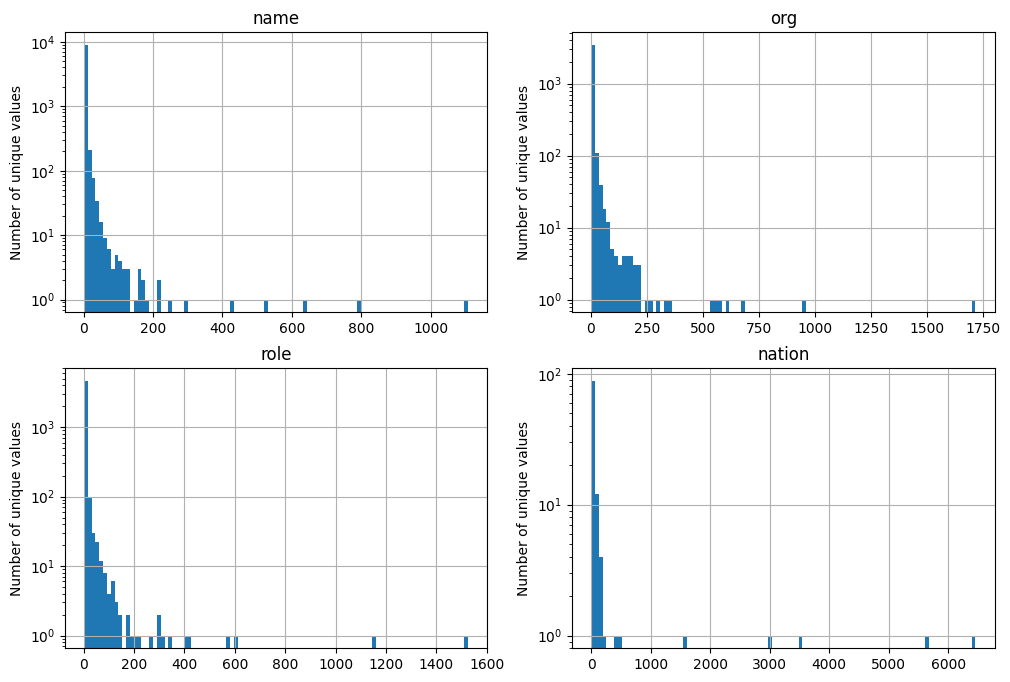

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for col, a in zip(ID_COLS, ax.flatten()):
    quotes[col].value_counts().reset_index()["count"].hist(bins=100, ax=a)
    a.set_title(col)
    a.set_yscale("log")
    a.set_xlabel("")
    a.set_ylabel("Number of unique values")

## Generate spokes table
I leave the quotes to one side and create a table with unique values only to operate on.

This is better for performance (i.e., named entity recognition), kicks off the deduplication process with our initial sets, and preserves the original columns in a separate dataframe during deduplication process.


In [12]:
import hashlib

# Generate a spoke id for each unique combination of the ID cols
quick_hash = lambda x: hashlib.md5(x.encode("utf-8")).hexdigest()
quotes["address"] = quotes.apply(
    lambda row: ", ".join([str(row[col]) for col in ID_COLS if pd.notna(row[col])]),
    axis=1,
)
quotes["spoke_id"] = quotes.apply(lambda row: quick_hash(row["address"]), axis=1)

# Create spokes table with counts of occurrences in the quotes df
spokes = (
    quotes[["spoke_id", "name", "org", "role", "nation", "address"]]
    .copy()
    .value_counts(dropna=False)
    .reset_index()
)

## Normalising text

In [13]:
from cleantext import clean
from nltk.corpus import stopwords
import nltk
import re

nltk.download("stopwords")
STOP_WORDS = set(stopwords.words("english"))


def clean_capitals(text):

    if isinstance(text, str):
        chunks = [i.strip() for i in text.split(" ")]
        out = []
        for n, chunk in enumerate(chunks):
            num_caps = sum(1 for c in chunk if c.isupper())
            if chunk in STOP_WORDS and n != 0:
                out.append(chunk)
            elif num_caps >= 2:
                out.append(chunk)
            else:
                out.append(chunk.capitalize())

        return " ".join(out)


def drop_punct(text):
    """Drops a limited number of non-alpha characters from a string.

    Intended to be used on names of people and organisations.

    Specifically, by default, this function removes full-stops, hyphens and
    quotation marks, common

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    if isinstance(text, str):
        text = text.replace(".", "").replace("-", " ").replace('"', "")
        return text


def drop_articles(
    text,
    articles=[
        "the",
        "a",
        "an",
        "one of the",
        "one of",
        "one",
        "another",
        "anonymous",
    ],
):
    """Removes articles from the start of words.

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """

    if isinstance(text, str):
        # try longest articles first (e.g., "one of the" before "one")
        for art in articles:
            pat = re.compile(r"^" + re.escape(art) + r" ", flags=re.IGNORECASE)
            new_text = pat.sub("", text, count=1)
            if new_text != text:
                return new_text
        return text


for col in ["name", "org", "role"]:
    spokes[col] = (
        spokes[col]
        .str.strip()
        .fillna("")
        .apply(lambda x: clean(x, fix_unicode=True, to_ascii=True, lower=False).strip())
        .apply(lambda x: drop_articles(x))  # basic articles
        .apply(lambda x: drop_punct(x))
        .apply(lambda x: drop_articles(x))  # titles
        .apply(lambda x: clean_capitals(x))
        .str.strip()
        .replace("", pd.NA)
    )

[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Missing records

### All identifying columns

In [14]:
spokes[ID_COLS].isna().sum()

name        56
org       3966
role      4057
nation    6130
dtype: int64

We should never have only role. Seeing as many names are roles, we can fill names that way.

In [15]:
# Fill name with role where name and org are missing
spokes.loc[
    spokes["name"].isna() & spokes["org"].isna() & spokes["role"].notna(),
    "name",
] = spokes["role"]

## Separating out real people

I'm aiming to have the name column only include real people with real names. I work to achieve this in two ways:
- Basic heuristics, clearing where keywords are present
- Using a named entity recognition (NER) model

In [16]:
# If the name is the same as the organisation, blank the name
spokes.loc[spokes["name"] == spokes["org"], "name"] = pd.NA

### Basic heuristics
There are some basic heuristics we can apply to see if a person is actually a person. 

- Spokespersons: What we see very frequently in the names is "A spokesperson from XXXX" or "A source at XXXX" and suchlike.
- None: There are also a few records where the LLM has returned something along the lines of "None" or "Not applicable".

In [17]:
spokes_indicators = [
    "spokesperson",
    "spokesman",
    "spokeswoman",
    "spokespeople",
    "officer",
    "official",
    "officials",
    "representatives",
    "communications",
    "source",
    "sources",
    "anonymous",
    "minister",
    "ministers",
    "writer",
    "writers",
    "author",
    "authors",
    "analyst",
    "analysts",
    "unidentified",
    "office",
    "soldier",
    "soldiers",
    "veteran",
    "veterans",
    "mp",
    "mps",
    "member",
    "members",
    "signatory",
    "signatories",
    "advisor",
    "figure",
    "figures",
    "reader",
    "terrorist",
    "terrorists",
    "staff",
    "staffer",
    "former",
    "senior",
    "aide",
    "adviser",
    "advisers",
    "chair",
    "chairman",
    "chairperson",
    "chairwoman",
    "ceo",
    "team",
    "employee",
]

# Check name for spokes indicators
is_spoke = (
    spokes["name"]
    .fillna("")  # avoid NA / NaN
    .str.lower()
    .apply(lambda x: any(ind in x.split() for ind in spokes_indicators))
)

# If spoke, set name to role and blank name
spokes.loc[is_spoke, "role"] = spokes["name"]
spokes.loc[is_spoke, "name"] = pd.NA

# Some names are just "NA" or similar, we set these to blank
negative_indicators = [
    "none",
    "n/a",
    "na",
    "not applicable",
    "not available",
    "unknown",
]

# Set to blank if negative indicator in name or organisation
for col in ["name", "org", "role"]:
    spokes.loc[spokes[col].str.lower().isin(negative_indicators), col] = pd.NA

### Named-Entity Recognition
Whilst the above

In [18]:
def get_type(
    text,
    labels=["person", "organisation", "document", "country", "location"],
    cache={},
    threshold=0.35,
):
    if text in cache:
        return cache[text]
    entities = ner_model.predict_entities(text, labels, threshold=threshold)
    if len(entities) > 0:
        entity_types = set([ent["label"] for ent in entities])
        if len(entity_types) == 1:
            return list(entity_types)[0]
        elif len(entity_types) > 1:
            if "person" in entity_types:
                return "person"
            elif "organisation" in entity_types:
                return "organisation"
            elif "document" in entity_types:
                return "document"
            elif "country" in entity_types:
                return "country"
            elif "location" in entity_types:
                return "location"
    else:
        return "other"


with open("cache/name_types.json", "r") as f:
    cache = json.load(f)

all_names = spokes["name"].dropna().astype(str).unique().tolist()
name_types = {}
for name in tqdm(all_names):
    name_types[name] = get_type(name, cache=cache)

spokes["ner_type"] = spokes["name"].map(name_types)

other_addresses = spokes.loc[spokes["ner_type"] == "other"]["address"].values

# For failures, try the addresses
for addr in other_addresses:
    name_types[addr] = get_type(
        addr,
        labels=["person", "anonymous", "formal title", "organisation", "group"],
        cache={},
        threshold=0.5,
    )
spokes["ner_type"] = spokes["name"].map(name_types)
with open("cache/name_types.json", "w") as f:
    json.dump(name_types, f, indent=4)

100%|██████████| 7036/7036 [00:08<00:00, 878.97it/s] 


In [19]:
# Where ner_type is organisation, fillna in org with name
spokes.loc[spokes["ner_type"] == "organisation", "org"] = spokes.loc[
    spokes["ner_type"] == "organisation", "org"
].fillna(spokes.loc[spokes["ner_type"] == "organisation", "name"])

# Where ner_type is not person or org, fillna in name with role
spokes.loc[~spokes["ner_type"].isin(["person", "organisation"]), "name"] = spokes.loc[
    ~spokes["ner_type"].isin(["person", "organisation"]), "name"
].fillna(spokes.loc[~spokes["ner_type"].isin(["person", "organisation"]), "role"])

# Blank out name where ner_type isn't person
spokes.loc[~spokes["ner_type"].isin(["person"]), "name"] = pd.NA

In [20]:
print("Unique counts after initial clean:")
print(spokes[ID_COLS].nunique())

print("\n")
print(f"Unique rows: {len(spokes.drop_duplicates(subset=ID_COLS))}")

Unique counts after initial clean:
name      6007
org       3536
role      4807
nation     112
dtype: int64


Unique rows: 13072


# Vertical deduplication

In [21]:
from tqdm import tqdm
import networkx as nx
from annoy import AnnoyIndex

from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("BAAI/bge-base-en-v1.5")


def get_deduped_items(
    docs: list[str], weights: list[float | int] = None, thresh=0.7, verbose=False
) -> dict:

    embeddings = embedding_model.encode(docs)
    if weights is not None:
        weights = dict(zip(docs, weights))
    else:
        weights = {}

    f = embeddings.shape[1]
    t = AnnoyIndex(f, "angular")
    for i, v in enumerate(embeddings):
        t.add_item(i, v)
    t.build(10)

    out = []

    if verbose:
        iterator = tqdm(range(len(embeddings)))
    else:
        iterator = range(len(embeddings))

    for idx in iterator:
        neighbours = t.get_nns_by_item(idx, 100, include_distances=True)
        for n, row in enumerate(zip(*neighbours)):
            similarity = 1 - row[1]
            if idx != row[0] and similarity >= thresh:
                d = {
                    "source_idx": idx,
                    "target_idx": row[0],
                    "similarity": similarity,
                    "source_name": docs[idx],
                    "target_name": docs[row[0]],
                }
                out.append(d)

    if len(out) == 0:
        return {}, None

    distances = pd.DataFrame(out)

    G = nx.from_pandas_edgelist(
        distances, source="source_idx", target="target_idx", edge_attr="similarity"
    )
    # update nodes with names and weights
    for node in G.nodes:
        G.nodes[node]["name"] = docs[node]
        G.nodes[node]["weight"] = weights.get(
            docs[node], 1
        )  # Default to 1 if no weight

    # Get subgraphs
    components = list(nx.connected_components(G))

    # Return mapping of old to new, choosing the heaviest weighted name in each component
    mapping = {}
    for component in components:
        subgraph = G.subgraph(component)
        # Use max to get the node with highest weight (most important/frequent)
        heaviest_node = max(subgraph.nodes, key=lambda n: subgraph.nodes[n]["weight"])
        heaviest_name = subgraph.nodes[heaviest_node]["name"]
        for node in subgraph.nodes:
            if subgraph.nodes[node]["name"] != heaviest_name:
                mapping[subgraph.nodes[node]["name"]] = heaviest_name

    return mapping, distances


for col in ["name", "org", "role"]:
    totals = spokes.groupby(col)["count"].sum().reset_index()
    docs = totals[col].fillna("").to_list()
    weights = totals["count"].to_list()

    # Testing suggests we can go a little deeper on org
    if col == "org":
        thresh = 0.585
    else:
        thresh = 0.65

    mapping, distances = get_deduped_items(docs, weights=weights, thresh=thresh)
    for old, new in mapping.items():
        spokes.loc[spokes[col] == old, col] = new

In [22]:
print("Unique counts after vertical deduplication:")
print(spokes[ID_COLS].nunique())

print("\n")
print(f"Unique rows: {len(spokes.drop_duplicates(subset=ID_COLS))}")

Unique counts after vertical deduplication:
name      5900
org       2949
role      4279
nation     112
dtype: int64


Unique rows: 12088


In [23]:
import networkx as nx

# Min-max scaling function
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.1, 1))


def make_nodes(col, spokes):
    nodes = (
        (spokes.groupby(col)["count"].sum().reset_index().assign(type=col))
        .reset_index()
        .dropna(subset=[col])
    ).rename(columns={col: "label"})
    nodes["id"] = nodes.apply(lambda row: f"{col}_{row['index']}", axis=1)
    nodes.name = col
    return nodes


def make_edges(spokes, source_df, target_df, normalize=False):
    source_type = source_df.name
    target_type = target_df.name

    source_ids = source_df[["label", "id"]].set_index("label").to_dict()["id"]
    target_ids = target_df[["label", "id"]].set_index("label").to_dict()["id"]

    edges = (
        spokes[[source_type, target_type]]
        .value_counts()
        .reset_index()
        .rename(
            columns={
                source_type: "source",
                target_type: "target",
                "count": "value",
            }
        )
        .assign(source=lambda x: x["source"].map(source_ids))
        .assign(target=lambda x: x["target"].map(target_ids))
    )
    if normalize:
        edges["value"] = scaler.fit_transform(edges[["value"]])
    return edges


def make_nodes_and_edges(spokes, drop_orphans=True, normalize=False):

    name_nodes, org_nodes = (
        make_nodes("name", spokes),
        make_nodes("org", spokes),
    )

    edges = make_edges(spokes, name_nodes, org_nodes, normalize=normalize)

    # Create nodes and ensure they're in edges
    nodes = pd.concat([name_nodes, org_nodes], ignore_index=True)

    if drop_orphans:
        nodes = nodes.query("id in @edges.source or id in @edges.target")

    return nodes, edges


def make_graph(nodes, edges):

    G = nx.from_pandas_edgelist(edges, "source", "target", ["value"])

    # Set node attributes
    attr_dict = nodes.set_index("id").to_dict(orient="index")
    nx.set_node_attributes(G, attr_dict)

    # Get subgraphs
    subgraphs = list(nx.connected_components(G))
    print(f"Found {len(subgraphs)} subgraphs")

    # Map subgraph ID to nodes and dataframe
    subgraph_map = {}
    for i, sg in enumerate(subgraphs):
        for node in sg:
            subgraph_map[node] = i

    largest_sg = max(subgraphs, key=len)

    # Cluster largest subgraph only
    G_largest = G.subgraph(largest_sg)
    G_largest_clusters = nx.community.louvain_communities(
        G_largest, weight="value", resolution=2
    )
    G_largest_cluster_map = {}
    for i, cluster in enumerate(G_largest_clusters):
        for node in cluster:
            G_largest_cluster_map[node] = f"large_{i}"

    cluster_map = {**G_largest_cluster_map}

    # Cluster everything else

    G_sg = G.subgraph([node for node in G.nodes if node not in largest_sg])
    clusters = nx.community.louvain_communities(G_sg, weight="value", resolution=0.5)

    # Map nodes to their cluster
    for i, cluster in enumerate(clusters):
        for node in cluster:
            cluster_map[node] = f"other_{i}"

    nodes["subgraph"] = nodes["id"].map(subgraph_map)
    nodes["subgraph_size"] = nodes["subgraph"].map(nodes["subgraph"].value_counts())
    nodes["cluster"] = nodes["id"].map(cluster_map)

    return nodes, edges, G


nodes, edges = make_nodes_and_edges(spokes)
nodes, edges, G = make_graph(nodes, edges)

Found 1528 subgraphs


In [24]:
from cosmograph import cosmo

widget = cosmo(
    points=nodes,
    links=edges,
    point_id_by="id",
    point_label_by="label",
    point_size_by="count",
    link_source_by="source",
    link_target_by="target",
    disable_simulation=False,
    point_color_by="cluster",
)

widget

Cosmograph(background_color=None, disable_simulation=False, focused_point_ring_color=None, hovered_point_ring_…

In [25]:
# Iterate over nodes and update names and organisations in spokes using `get_deduped_items`
names_map = {}
orgs_map = {}

for idx, group in nodes.groupby("cluster"):

    for node_type in ["name", "org"]:

        entities = group[group["type"] == node_type]
        totals = entities[["label", "count"]].set_index("label")

        docs = entities["label"].to_list()
        weights = totals["count"].to_list()

        if len(docs) > 1:
            deduped, dists = get_deduped_items(docs, weights=weights, thresh=0.5)
            if node_type == "name":
                names_map.update(deduped)
            elif node_type == "org":
                orgs_map.update(deduped)

spokes["name"] = spokes["name"].map(names_map).fillna(spokes["name"])
spokes["org"] = spokes["org"].map(orgs_map).fillna(spokes["org"])

In [26]:
print("\n")
print("\n")
print("Unique counts after vertical deduplication:")
print(spokes[ID_COLS].nunique())

print(f"Total unique spokes: {len(spokes.drop_duplicates(subset=ID_COLS))}")





Unique counts after vertical deduplication:
name      5786
org       2886
role      4279
nation     112
dtype: int64
Total unique spokes: 11949


# Horizontal deduplication

In [27]:
spokes["org_id"] = spokes["org"].apply(
    lambda x: quick_hash(x) if pd.notna(x) else pd.NA
)

top_names = spokes.groupby("name")["count"].sum()
top_orgs = spokes.groupby("org")["count"].sum()
top_roles = spokes.groupby("role")["count"].sum()


class Person:
    def __init__(
        self,
        person_id=None,
        spoke_ids=None,
        name=None,
        org=None,
        all_orgs=None,
        role=None,
        nation=None,
        count=0,
    ):
        self.spoke_id = spoke_ids
        self.name = name
        self.org = org
        self.all_orgs = all_orgs
        self.role = role
        self.nation = nation
        self.count = count
        self.address = ", ".join(
            [str(i) for i in [name, org, role, nation] if pd.notna(i) and i != ""]
        )
        self.person_id = (
            quick_hash(self.address)
            if pd.notna(self.address) and self.address != ""
            else None
        )

    @staticmethod
    def _pick_org(candidates, top_orgs):
        if len(candidates["org"].unique()) == 1:
            return candidates["org"].iloc[0]
        else:
            # Pick the org with the highest total count
            candidates = candidates.copy()
            candidates["total_count"] = candidates["org"].map(top_orgs)
            candidates = candidates.sort_values(by="total_count", ascending=False)
            return candidates["org"].iloc[0]

    @classmethod
    def from_rows(cls, name, candidates, top_orgs):
        # Simply aggregate all candidates into a single person record

        # Pick the most common organization
        org = (
            cls._pick_org(candidates, top_orgs)
            if len(candidates["org"].dropna()) > 0
            else None
        )
        org = org if pd.notna(org) else None

        # Get all organizations this person is associated with
        all_orgs = (
            candidates.sort_values(by="count", ascending=False)["org"]
            .dropna()
            .unique()
            .tolist()
        )

        # Pick the most common role
        role_counts = candidates.groupby("role")["count"].sum()
        role = role_counts.idxmax() if len(role_counts) > 0 else None

        # Pick the most common nation
        nation_counts = candidates.groupby("nation")["count"].sum()
        nation = nation_counts.idxmax() if len(nation_counts) > 0 else None

        return cls(
            person_id=None,
            spoke_ids=candidates["spoke_id"].tolist(),
            name=name,
            org=org,
            all_orgs=all_orgs,
            role=role,
            nation=nation,
            count=candidates["count"].sum(),
        )

    def __repr__(self):
        return f"Person(name={self.name}, org={self.org}, role={self.role}, nation={self.nation}, count={self.count}, all_orgs={self.all_orgs})"

    def to_dict(self):
        return {
            "person_id": self.person_id,
            "spoke_ids": self.spoke_id,
            "name": self.name,
            "org": self.org,
            "all_orgs": self.all_orgs,
            "role": self.role,
            "nation": self.nation,
            "count": self.count,
            "address": self.address,
        }


all_people = []
for person in spokes["name"].dropna().unique():
    candidates = spokes[spokes["name"] == person][
        ["spoke_id", "name", "org", "role", "nation", "count", "address"]
    ].drop_duplicates()
    all_people.append(Person.from_rows(person, candidates, top_orgs))

In [28]:
people_df = pd.DataFrame([p.to_dict() for p in all_people])
mapping, edges = get_deduped_items(
    docs=[p.address for p in all_people],
    weights=[p.count for p in all_people],
    thresh=0.6,
)

if mapping:  # Only proceed if there are duplicates to merge
    # Create complete mapping from address to person object
    address_to_person = {p.address: p for p in all_people}

    # Process merges
    for old_address, new_address in mapping.items():
        # As python creates references, we can directly update the objects like this
        old_person = address_to_person[old_address]
        new_person = address_to_person[new_address]

        # Merge spoke ids
        new_person.spoke_id = list(set(new_person.spoke_id + old_person.spoke_id))

        # Merge all orgs
        new_person.all_orgs = list(set(new_person.all_orgs + old_person.all_orgs))

        # Update count
        new_person.count += old_person.count

    # Remove old people
    all_people = [p for p in all_people if p.address not in mapping.keys()]

In [29]:
# Add back to spokes
spokes["all_orgs"] = pd.NA
for p in all_people:
    records_to_replace = spokes["spoke_id"].isin(p.spoke_id)
    for field in [
        "name",
        "org",
        "role",
        "nation",
        "address",
        "all_orgs",
        "count",
    ]:
        if field == "all_orgs":
            spokes.loc[records_to_replace, field] = str(p.all_orgs)
        else:
            spokes.loc[records_to_replace, field] = getattr(p, field)

In [30]:
# update address for all spokes, they're out of sync by now
spokes["address"] = spokes.apply(
    lambda row: ", ".join(
        [str(row[col]) for col in ID_COLS if pd.notna(row[col]) and row[col] != ""]
    ),
    axis=1,
)

# Also counts
spokes_counts = quotes["spoke_id"].value_counts().to_dict()
spokes["count"] = spokes["spoke_id"].map(spokes_counts).fillna(0).astype(int)

In [31]:
print("\n")
print("\n")
print("Unique counts after horizontal deduplication:")
print(spokes[ID_COLS].nunique())

print(f"Total unique spokes: {len(spokes.drop_duplicates(subset=ID_COLS))}")





Unique counts after horizontal deduplication:
name      6873
org       3189
role      4047
nation     117
dtype: int64
Total unique spokes: 10584


In [32]:
import pycountry


def is_nation(x):
    if pd.isna(x):
        return False
    elif x == "UNA":
        return True
    try:
        match = pycountry.countries.lookup(x)
        return True
    except LookupError:
        return False


spokes["nation"].replace({"PLE": "PSE"}, inplace=True)
spokes["nation"] = spokes["nation"].apply(lambda x: x if is_nation(x) else pd.NA)

/tmp/ipykernel_76029/1139529058.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spokes["nation"].replace({"PLE": "PSE"}, inplace=True)


In [33]:
UN_FLAGS = [
    "United Nations",
    "UN",
    "UNICEF",
    "UNHCR",
    "UNRWA",
    "OCHA",
    "Office for the Coordination of Humanitarian Affairs",
    "WHO",
    "World Health Organization",
    "WFP",
    "World Food Programme",
    "FAO",
    "Food and Agriculture Organization",
    "International Committee of the Red Cross",
    "International Federation of Red Cross and Red Crescent Societies",
    "World Bank",
    "International Criminal Court",
    "International Monetary Fund",
    "International Court of Justice",
]

# Set nation to UN where it looks like a UN agency
spokes.loc[spokes["org"].isin(UN_FLAGS), "nation"] = "INT"

In [34]:
org_mask = ~spokes["org"].isna() & spokes["name"].isna().copy()
orgs = spokes[org_mask]
nation_orgs = (
    orgs[orgs["nation"].notna()]
    .groupby("org")["nation"]
    .value_counts()
    .unstack()
    .assign(total=lambda x: x.notnull().sum(axis=1))
)
# If total == 1, we can fill in the nation for this org with a dict
single_nation_orgs = (
    nation_orgs[nation_orgs["total"] == 1]
    .stack()
    .reset_index()[["org", "nation"]]
    .query("nation != 'total'")
    .set_index("org")["nation"]
    .to_dict()
)

# Replace missing nations where we have a single known nation for the org
for org, nation in single_nation_orgs.items():
    spokes.loc[(spokes["org"] == org) & (spokes["nation"].isna()), "nation"] = nation

In [ ]:
spokes[spokes.nation.isna()].drop_duplicates(subset=["name", "org"])

,spoke_id,name,org,role,nation,address,count,ner_type,org_id,all_orgs
33,1f25a717b9da7abb77bd6b6029964a55,<NA>,<NA>,<NA>,<NA>,,43,other,<NA>,<NA>
61,c5586d98ff82f938522d182642181384,<NA>,Palestine Action,<NA>,<NA>,Palestine Action,30,NaN,35e4d7d0a4b84b9fd838d576194182e5,<NA>
66,466b51d87a3662a4f06d0a37fbdeea59,<NA>,European Union,<NA>,<NA>,European Union,28,NaN,9a18968af130ca0040b68b9e2eec4838,<NA>
82,a73b267c065911f6b2a7661a78cd6c71,Catherine Russell,Unicef,Executive Director,<NA>,"Catherine Russell, Unicef, Executive Director",24,person,4985272c04dc589f4e5fd2a57e279c4b,"['Unicef', ""United Nations Children's Fund"", '..."
131,635c7e9c15399d266a7aff545b2374e9,Claudine Gay,Harvard University,President,<NA>,"Claudine Gay, Harvard University, President",18,person,cdd16461ab27f5bce52a8d94f8632292,['Harvard University']
...,...,...,...,...,...,...,...,...,...,...
17912,00212256f5efd18c0147214ac03624cb,Chris Nineham,Stop the War,Vice Chair,<NA>,"Chris Nineham, Stop the War, Vice Chair",1,person,cb04ccfd09c7fb489aaa2e8ba8c925bd,['Stop the War']
17913,0026b3b6d4c3fd80928133567f392117,Halle Berry,None,Actress,<NA>,"Halle Berry, Actress",1,person,<NA>,[]
17916,003fc5a19fb7c35570c6a3ee3c3e4b78,Richard Goldberg,Foundation for Defense of Democracies,Senior Advisor,<NA>,"Richard Goldberg, Foundation for Defense of De...",1,person,3f07cf7c922134ae279480535ade4603,['Foundation for Defense of Democracies']
17917,00400e3b8817a95ca3b4ae8bc1b5ab4b,Tim Whitehouse,None,Former EPA Attorney,<NA>,"Tim Whitehouse, Former EPA Attorney",1,person,<NA>,[]
